# Application of Shapley Value in German-Credit Data

In [1]:
# Load the Required packages 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Package for Shapley Value
import shap

# The explanation is divided in two parts :
    Section 1: Building the Model(Provided just for completeness, not so important in understanding Shapley )
    section 2: Use of Shapley Value in model explainability

# Section 1: Building the Model

In [6]:
# Loading the dataset

In [3]:
data = pd.read_csv(r'C:\Users\PRATIK KR ADAK\Desktop\White paper\Dataset\german_credit.csv')
data.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [8]:
# Train-Test Split

In [4]:
Risk= data['Creditability']          
df2=data.drop(['Creditability'],axis=1)
X_train,X_test,Y_train,Y_test = train_test_split(df2,Risk,test_size=0.20,random_state = 30)

In [5]:
#Building the Model.
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bytree=1.0, gamma=0.2, learning_rate=0.05,
              max_delta_step=0, max_depth=3
              , min_child_weight= 1.0, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1.0)
#Fit the dataset
clf.fit(X_train,Y_train)

#Prediction on the test dataset.
pred = clf.predict(X_test)

[18:37:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [11]:
#Ignore the above Warning.

In [27]:
# Accuracy Score on test dataset
accuracy_test = accuracy_score(Y_test,pred)
print('\naccuracy_score on test dataset : ', accuracy_test)


accuracy_score on test dataset :  0.745


# Section 2 :Use of Shapley Value

In [6]:
#Uses Tree SHAP algorithms to explain the output of ensemble tree models.
#Here model object is the input.The machine learning model that we want to explain.
explainer = shap.TreeExplainer(clf)

#Shapley values for the features and output of the model.
shap_values = explainer.shap_values(X_train)

Variable importance from Shapley Value :
A variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power.

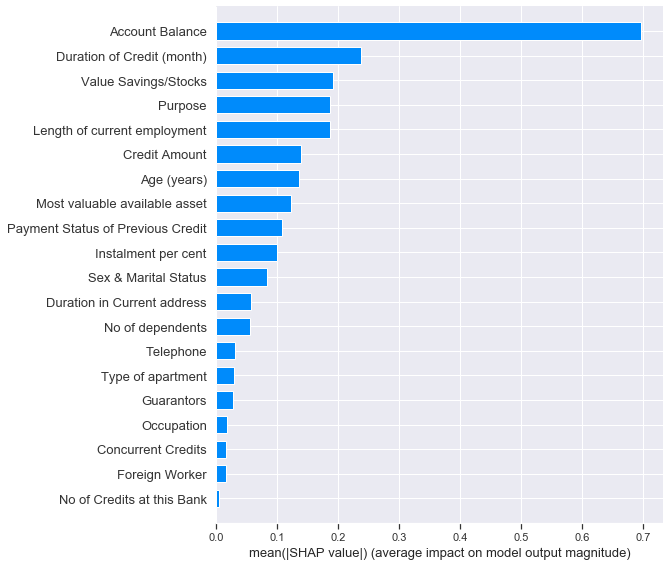

In [34]:
shap.summary_plot(shap_values,X_train, plot_type="bar")

comment : Here we see that account balance, duration of credit, value of savings/stocks, length of current employment,etc are some of the important features in classifying customers as good or bad credit risk customers.

In [ ]:
#2.2)summary Plot: This plot is made of many dots.  
    #Each dot has three characteristics:
             #1.Vertical location shows what feature it is depicting
             #2.Color shows whether that feature was high or low for that observation.
             #3.Horizontal location shows whether the effect of that value caused a higher or lower prediction.
    #This shows the Shapley values on the x-axis. Here, all the values on the left represent the observations that shift the predicted value in the negative direction while the points on the right contribute to shifting the prediction in a positive direction. All the features are on the left y-axis. 

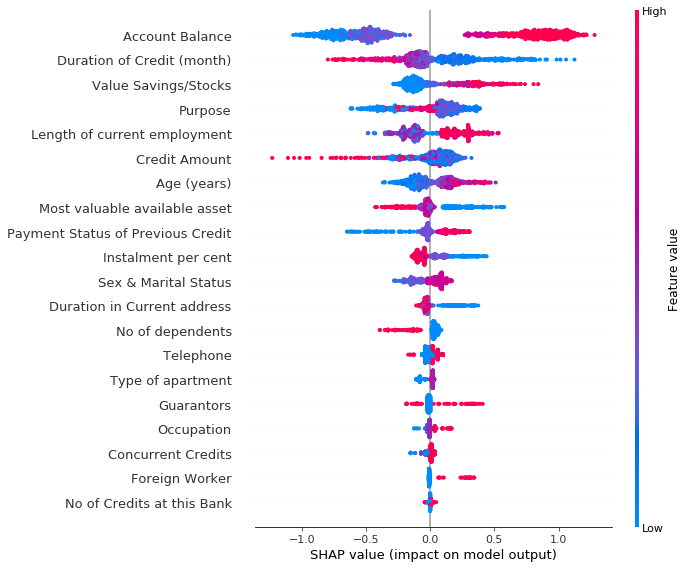

In [18]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

comment : From the above graph, we see that more the value of savings/stocks high, more is the chance of customers to payback the loan. Also if the customer is a tenured employee, that proves his financial stability which increases the chance of creditability of the customer.

Pairwise Interaction Plot : This plot tells us the pairwise interaction of different features (in descending order of importance) for the model predictions

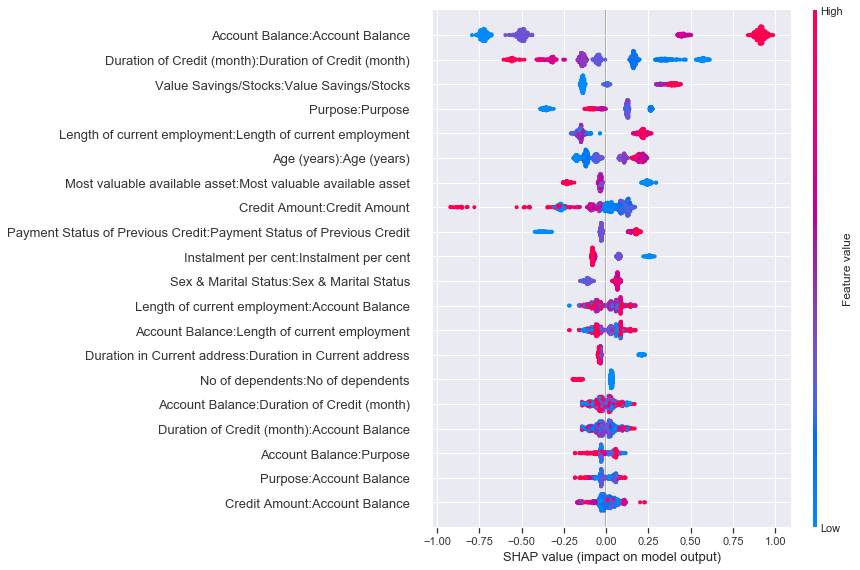

In [38]:
#Make the shap interaction values for features
siv_xgbc = explainer.shap_interaction_values(X_train)
dim = siv_xgbc.shape
shap_interaction_values_2d = np.reshape(np.ravel(siv_xgbc), (dim[0], dim[1]*dim[2]))

# make all pairs of features
x2 = X_train[np.repeat(X_train.columns.tolist(), len(X_train.columns))]
x2.columns =  [i+":"+str(j) for i in X_train.columns for j in X_train.columns]

#Plot the shap interaction values for features 
shap.summary_plot(shap_interaction_values_2d, x2, sort=True)

Comment : Interaction between account balance and length of current emplyment has an significant role in predicting the output.

In [ ]:
#2.4) Dependence plot for features :
#Each dot is a single prediction (row) from the dataset.
#The x-axis is the value of the feature.
#The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model in presence of anpther feature for that sample's prediction.

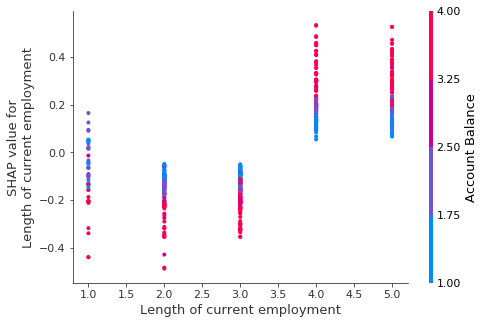

In [14]:
shap.dependence_plot("Length of current employment",shap_values,X_train,interaction_index="Account Balance")

Comment :Also from the dependence plot we see that although the length of current employment is same for two customers, higher account balance increases the chance of creditability.

In [15]:
#Dependence plot for all posible feature combination.

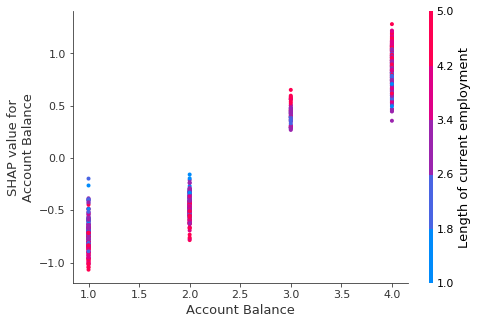

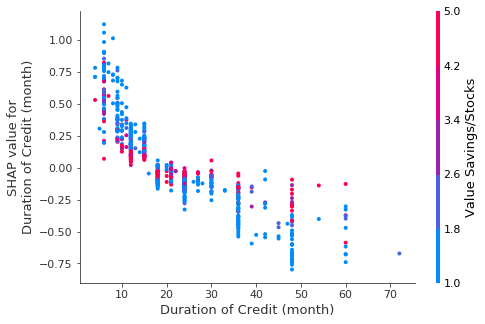

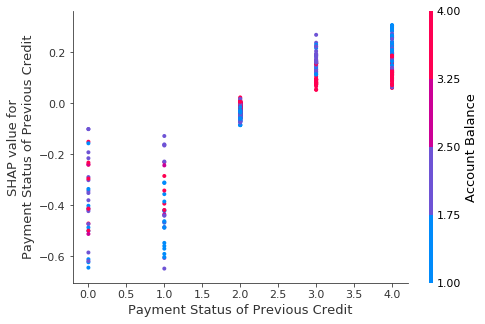

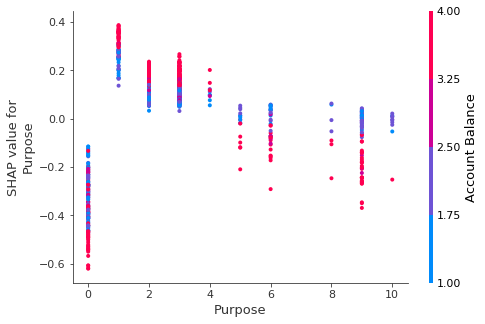

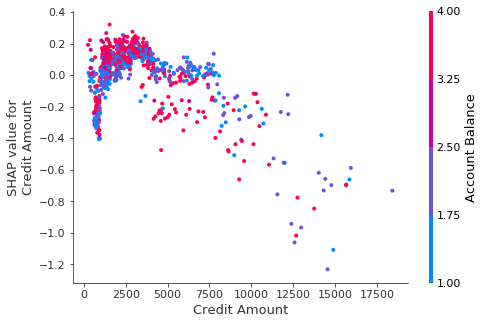

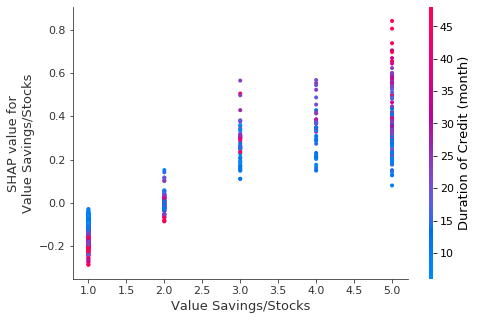

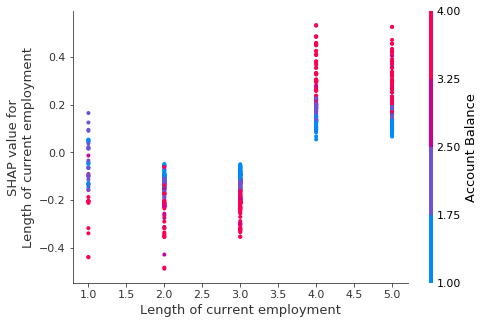

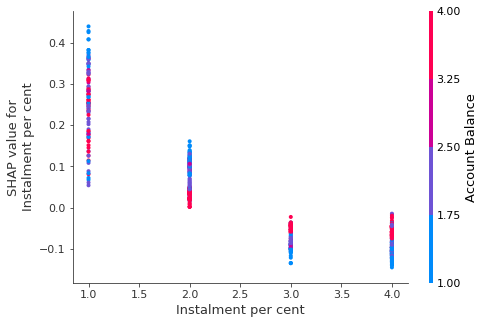

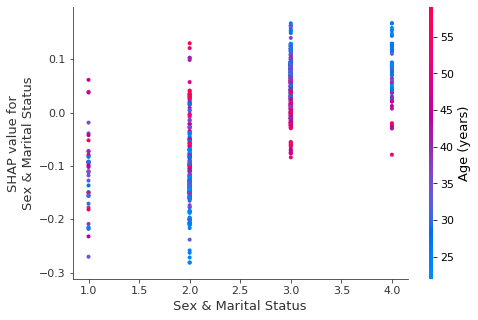

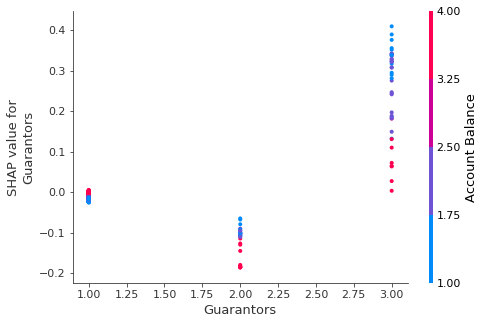

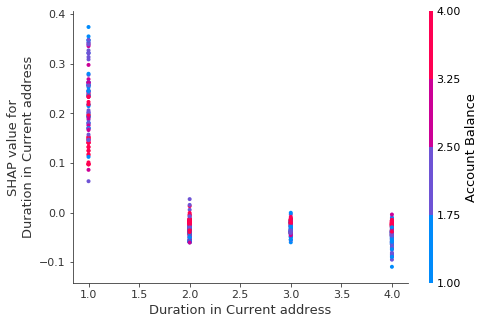

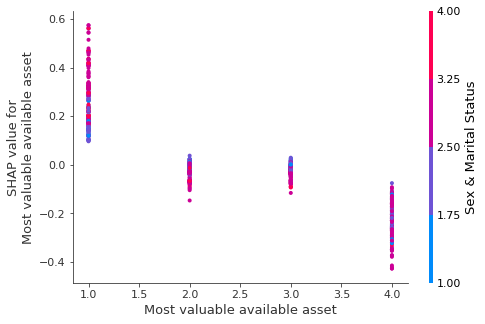

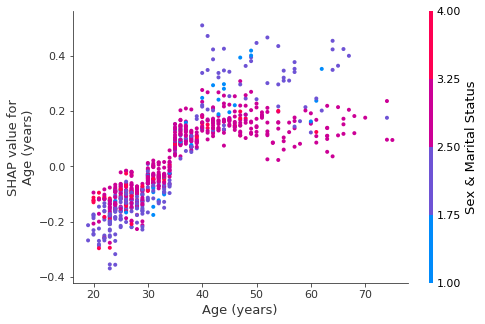

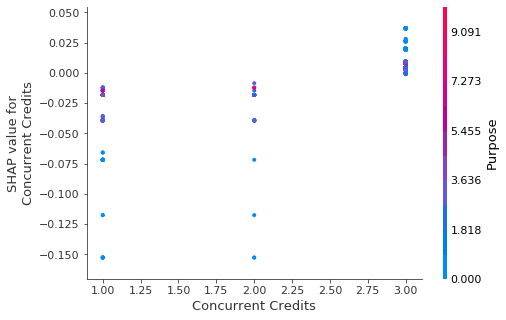

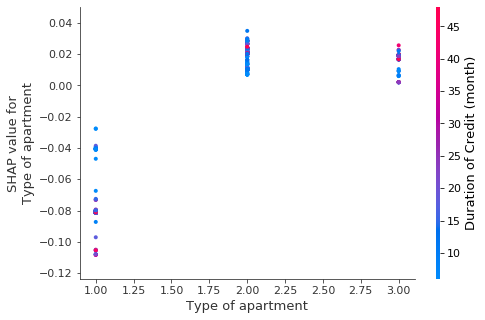

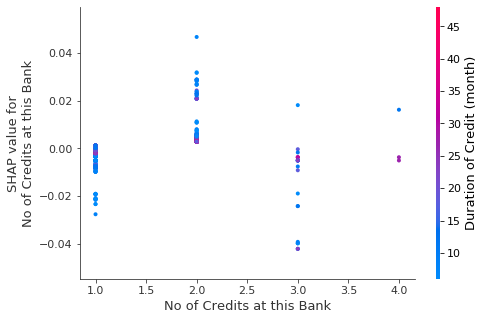

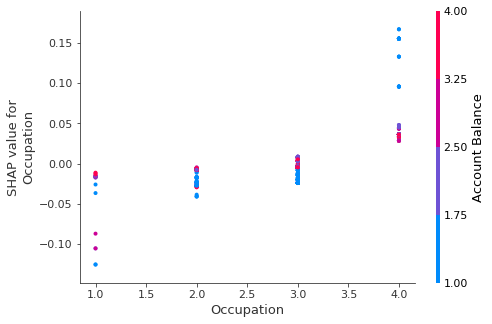

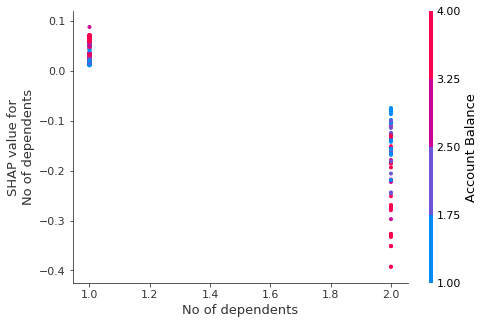

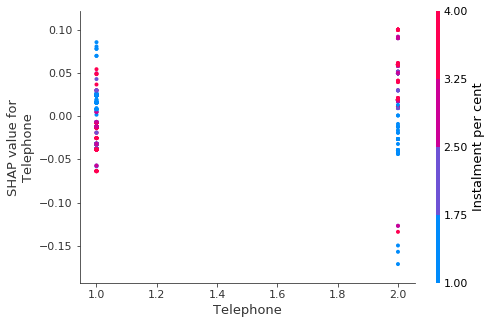

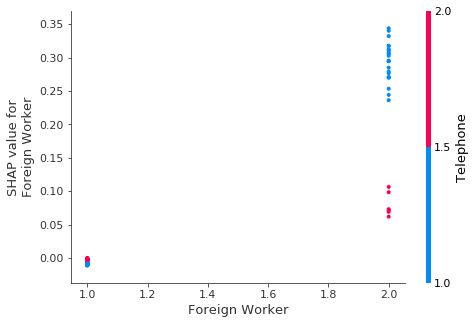

In [13]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)

In [54]:
#2.6) Force plot : The base value E (yhat) is “the value that would be predicted if one did not know any features for the current output.” In other words, it is the mean prediction, or mean (yhat). A log odds transformation has been done. The output value is the prediction for that observation.

In [16]:
# load JS visualization code to notebook
shap.initjs()

In [19]:
# visualize the first prediction's explaination with default colors
shap.force_plot(explainer.expected_value, shap_values[2,:], X_train.iloc[2,:])

Comment : Here we have plotted for only one observation.The important features having higher contribution towards higher predicted probability of that observation can be obtained from the plot. This is Java script visualization, doesn't get stored. You can try on your model.

In [7]:
#######################################################  END   ########################################################